# Author Classifier

In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.utils.class_weight import compute_class_weight

In [2]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
#                     color="white" if cm[i, j] > thresh else "black")
                     color = "white" if i != j else "black")

#                     color="white")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color = "white" if i != j else "black")
#                     color="white" if cm[i, j] > thresh else "black")
#                    color = "white")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [3]:
# Read the CSV file into a DataFrame
sentences = pd.read_csv('grand_sentences.csv',encoding='latin-1')

In [4]:
X = sentences['Sentence']
y = sentences['Author']
X = X.replace(np.nan, '')

# Check class distribution
print(sentences['Author'].value_counts())

Author
Hemingway     3296
Faulkner      3119
Lawrence      2331
Orwell        2026
Fitzgerald    1957
Austen        1751
Wharton       1499
Kerouac        908
Name: count, dtype: int64


In [5]:
# For plotting confusion matrix heatmap
target_names = sentences['Author'].unique()

In [6]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Convert the sentences into TF-IDF vectors
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [8]:
# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

In [9]:
# Train an SVC model
svc_model = SVC(kernel='linear', C=1.0, class_weight=class_weight_dict)
svc_model.fit(X_train_tfidf, y_train)

SVC(class_weight={'Austen': 1.2044400855920114, 'Faulkner': 0.6864329268292683,
                  'Fitzgerald': 1.0735060394151303,
                  'Hemingway': 0.6374575311438279,
                  'Kerouac': 2.3355809128630707, 'Lawrence': 0.8977272727272727,
                  'Orwell': 1.0397937192118227, 'Wharton': 1.4107142857142858},
    kernel='linear')

In [10]:
# Make predictions on the test set
y_pred = svc_model.predict(X_test_tfidf)

In [11]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'SVC (C=1.0) Accuracy: {accuracy * 100:.2f}%')

SVC (C=1.0) Accuracy: 69.95%


In [36]:
# Create and print confusion matrix
from sklearn import metrics

c_matrix = metrics.confusion_matrix(y_test, y_pred)
print(c_matrix)

y_actual = pd.Series(y_test, name='Actual').astype('category')
y_predicted = pd.Series(y_pred, name='Predicted').astype('category')

#create confusion matrix
pd.set_option('display.width', 132)
print('\n  ', pd.crosstab(y_actual, y_predicted),'\n')
from sklearn.metrics import classification_report
print(classification_report(y_actual, y_predicted, target_names=target_names))

[[265   7   4  18   4  14  10  27]
 [ 10 505  14  47   9  32  29  13]
 [ 16  14 230  32  10  34  35  13]
 [ 13  32  40 444  25  42  44   7]
 [  2  14  16  12 116   9  15   1]
 [ 10  17  19  40  13 294  34  23]
 [  7  15   9  34   6  20 304   7]
 [ 14  11  19   8   3  27  15 205]]

   Predicted  Austen  Faulkner  Fitzgerald  Hemingway  Kerouac  Lawrence  Orwell  Wharton
Actual                                                                                
Austen         38        66          33         69       16        50      39       38
Lawrence       26        57          46         49       24        36      41       26 

              precision    recall  f1-score   support

      Austen       0.79      0.76      0.77       349
    Lawrence       0.82      0.77      0.79       659
   Hemingway       0.66      0.60      0.63       384
    Faulkner       0.70      0.69      0.69       647
     Wharton       0.62      0.63      0.63       185
      Orwell       0.62      0.65      0

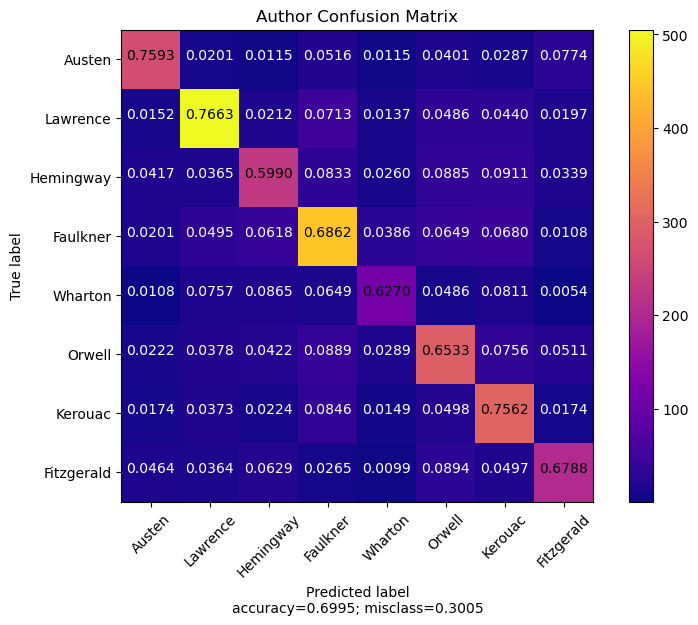

In [14]:
#Plot confusion matrix
plot_confusion_matrix(c_matrix, target_names, title='Author Confusion Matrix', cmap="plasma")

In [24]:
#print precision value of model
precision = metrics.precision_score(y_test, y_pred, average='weighted')
print(f'Precision Score: {precision * 100:.2f}%')

#print recall value of model
recall = metrics.recall_score(y_test, y_pred, average='weighted')
print(f'Recall Score: {recall * 100:.2f}%')

#print f1 score of model
f1 = metrics.f1_score(y_test, y_pred, average='weighted')
print(f'F1 Score: {f1 * 100:.2f}%')

Precision Score: 70.33%
Recall Score: 69.95%
F1 Score: 70.03%
